<a href="https://colab.research.google.com/github/rodrigogomesrc/DataScienceBES/blob/main/An%C3%A1lise_de_Turmas_(2017_1_2018_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobre

Análise das turmas de graduação da UFRN e do Bacharelado em Engenharia de Software.

Essa análise visa responder as seguintes perguntas:

- Quantidade de alunos em uma turma influencia na nota média dos alunos?
- Quantidade de alunos em uma turma influencia na proporção de trancamentos?


## Carregamento e tratamento dos dados

In [ ]:
# Importar bibliotecas e carregar os dados


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import csv
import scipy
import scipy.stats
from scipy import stats

#Dados Públicos da UFRN (https://dados.ufrn.br/)

matriculas_20181 = pd.read_csv("/content/matricula-componente-20181.csv", sep=";")
matriculas_20181["semestre"] = "20181"

matriculas_20172 = pd.read_csv("/content/matricula-componente-20172.csv", sep=";")
matriculas_20172["semestre"] = "20172"

matriculas_20171 = pd.read_csv("/content/matricula-componente-20171.csv", sep=";")
matriculas_20171["semestre"] = "20171"

turmas_20181 = pd.read_csv("/content/turmas-2018.1.csv", sep=";")
turmas_20181["semestre"] = "20181"

turmas_20172 = pd.read_csv("/content/turmas-2017.2.csv", sep=";")
turmas_20172["semestre"] = "20172"

turmas_20171 = pd.read_csv("/content/turmas-2017.1.csv", sep=";")
turmas_20171["semestre"] = "20171"

data_turmas = turmas_20181.append(turmas_20172)
data_turmas = data_turmas.append(turmas_20171)

data = matriculas_20181.append(matriculas_20172)
data = data.append(matriculas_20171)

componentes = pd.read_csv("/content/componentes-curriculares-presenciais.csv", sep=";")

# Dados anonimizados fornecidos pela coordenação do Bacharelado em Engenharia de Software (BES)
bes = pd.read_csv("/content/bes.csv", sep=",")

# Estando como True retira os desistentes mantendo somente os alunos com status de "Aprovado", "Reprovado" e "Aprovado por Nota" na análise
# Ao retirar os desistentes não é possível fazer a análise de trancamentos, tendo em vista que os alunos que trancaram são retirados dos dados
RETIRAR_DESISTENTES = True

if(RETIRAR_DESISTENTES):
  nd_statuses = ["APROVADO", "REPROVADO", "APROVADO POR NOTA"]
  data_nd = data[data['descricao'].isin(nd_statuses)]
  data = data_nd

# pega um dataframe com o id das turmas e componentes curriculares
turma_componente = data_turmas.filter(items=['id_turma', 'id_componente_curricular', 'semestre'])
turma_componente = turma_componente.rename(columns={"id_componente_curricular": "id_componente"})

# relaciona os ids das turmas com os ids e código dos componentes curriculares
componente_codigo = componentes.filter(items=['id_componente', 'codigo'])
turma_componente = turma_componente.merge(componente_codigo, on="id_componente")
turma_componente.drop_duplicates(subset="id_turma", keep="first", inplace=True)
turma_componente = turma_componente.filter(items=['id_turma', 'codigo'])

# pega os códigos de todas as turmas e separa somente os que correspondem ao BES
bes_turmas = bes['Código']
ids_turmas_bes = turma_componente[turma_componente['codigo'].isin(bes_turmas)]
ids_turmas_bes = ids_turmas_bes['id_turma']
ids_turmas_bes = ids_turmas_bes.reset_index(level=0)
ids_turmas_bes = ids_turmas_bes['id_turma']



## Preparação dos dados

In [ ]:
#pegar somente a informação se uma turma é ou não de graduação
data_turmas = data_turmas.filter(items=['id_turma', 'nivel_ensino', 'semestre'])


# pegar a quantidade de trancamentos por turma
qtd_trancados = data
qtd_trancados['TRANCADOS'] = [1 if valor == 'TRANCADO' else 0 for valor in qtd_trancados.descricao]
qtd_trancados.drop_duplicates(subset="discente", keep="first", inplace=True)
qtd_trancados = qtd_trancados.filter(items=['id_turma', 'TRANCADOS'])
qtd_trancados = qtd_trancados.groupby('id_turma').sum()

#qtd_trancados = qtd_trancados.sort_values(by=['TRANCADOS'], ascending=False)

#Separa somente as colunas selecionadas
turma_count = data.filter(items=['id_turma', 'discente', 'semestre'])

'''
Remover os dados duplicados, já que cada aluno vai aparecer 3 vezes na relação entre
aluno e turma nos dados porque cada registro vai corresponder a 1 unidade. Dessa forma 
é necessário remover os duplicados para que ao contar a quantidade de alunos nas turmas
não conte o mesmo aluno mais de uma vez
'''

turma_count.drop_duplicates(subset="discente", keep="first", inplace=True)

# agrupa os dados por turma para contar quantos alunos tem em cada turma
turma_count = turma_count.groupby('id_turma').count()

# cria um dataframe só com a turma e a média final de cada aluno naquela turma
media_turma = data.filter(items=['id_turma', 'media_final'])
media_turma = media_turma.dropna()

#troca a vírgula por ponto nos valores numéricos e converte para float para permitir o cálculo
media_turma['media_final'] = media_turma['media_final'].str.replace(',', '.')
media_turma['media_final'] = pd.to_numeric(media_turma['media_final'], downcast='float')

#faz a média das médias finais de todos os alunos de uma turma, calculando a média geral da turma
media_turma = media_turma.groupby('id_turma').mean()

# junta os dataframes da média da turma com o dataframe com a quantidade de alunos
df = pd.merge(turma_count, media_turma, right_index=True, left_index=True)
df = df.rename(columns={"discente": "QTD_ALUNOS", "media_final": "MEDIA_FINAL"})

# junta a quantidade de trancados na turma
df = pd.merge(df, qtd_trancados, right_index=True, left_index=True)

# Separa somente os dados de graduação
grad = df.reset_index(level=0)

grad.drop('semestre', axis='columns', inplace=True)

grad = grad.merge(data_turmas, on="id_turma", how="left")
grad.drop_duplicates(subset="id_turma", keep="first", inplace=True)
grad = grad[grad['nivel_ensino'] == "GRADUAÇÃO"]
grad = grad.rename(columns={'id_turma': 'TURMA', 'semestre': 'SEMESTRE'})
grad = grad.filter(items=['TURMA', 'QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS', 'SEMESTRE'])

grad_20181 = grad[grad['SEMESTRE'] == '20181']
grad_20172 = grad[grad['SEMESTRE'] == '20172'] 
grad_20171 = grad[grad['SEMESTRE'] == '20171'] 

# Separando somente as turmas do BES
bes_df20181 = grad_20181[grad_20181['TURMA'].isin(ids_turmas_bes)]
bes_df20172 = grad_20172[grad_20172['TURMA'].isin(ids_turmas_bes)]
bes_df20171 = grad_20171[grad_20171['TURMA'].isin(ids_turmas_bes)]


## Preparação dos dados para gerar os gráficos

In [ ]:
# pega todas as turmas com a mesma quantidade de alunos e faz uma média
'''
Faz a média da média final de cada turma com a mesma quantidade de alunos, para
diminuir a quantidade de pontos no scatter plot
'''

#2018.1

qtd_20181 = grad_20181.filter(items=['QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS', 'SEMESTRE'])

#RETIRAR O SEMESTRE E DEPOIS JUNTAR NOVAMENTE DEPOIS DE FAZER A CONTAGEM

# pega a quantidade de turmas com n quantidade de alunos
sizes20181 = qtd_20181.copy()
sizes20181['QTD_TURMAS'] = 1
sizes20181 = sizes20181.groupby('QTD_ALUNOS').count()
sizes20181 = sizes20181.filter(items=['QTD_ALUNOS', 'QTD_TURMAS'])

qtd_20181 = qtd_20181.groupby('QTD_ALUNOS').mean()
qtd_20181.reset_index(level=0, inplace=True)
qtd_20181['PORCENTAGEM_TRANCAMENTOS'] = (qtd_20181['TRANCADOS'] / qtd_20181['QTD_ALUNOS']) * 100

qtd_20181 = qtd_20181.merge(sizes20181, on="QTD_ALUNOS")

#somente as turmas do BES
qtd_bes20181 = bes_df20181.filter(items=['QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS'])

# pega a quantidade de turmas com n quantidade de alunos
sizes_20181 = qtd_bes20181.copy()
sizes_20181['QTD_TURMAS'] = 1
sizes_20181 = sizes20181.groupby('QTD_ALUNOS').count()
sizes_20181 = sizes20181.filter(items=['QTD_ALUNOS', 'QTD_TURMAS'])

qtd_bes20181 = qtd_bes20181.groupby('QTD_ALUNOS').mean()
qtd_bes20181.reset_index(level=0, inplace=True)
qtd_bes20181['PORCENTAGEM_TRANCAMENTOS'] = (qtd_bes20181['TRANCADOS'] / qtd_bes20181['QTD_ALUNOS']) * 100

qtd_bes20181 = qtd_bes20181.merge(sizes_20181, on="QTD_ALUNOS")

#2017.2

qtd_20172 = grad_20172.filter(items=['QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS', 'SEMESTRE'])

#RETIRAR O SEMESTRE E DEPOIS JUNTAR NOVAMENTE DEPOIS DE FAZER A CONTAGEM

# pega a quantidade de turmas com n quantidade de alunos
sizes20172 = qtd_20172.copy()
sizes20172['QTD_TURMAS'] = 1
sizes20172 = sizes20172.groupby('QTD_ALUNOS').count()
sizes20172 = sizes20172.filter(items=['QTD_ALUNOS', 'QTD_TURMAS'])

qtd_20172 = qtd_20172.groupby('QTD_ALUNOS').mean()
qtd_20172.reset_index(level=0, inplace=True)
qtd_20172['PORCENTAGEM_TRANCAMENTOS'] = (qtd_20172['TRANCADOS'] / qtd_20172['QTD_ALUNOS']) * 100

qtd_20172 = qtd_20172.merge(sizes20172, on="QTD_ALUNOS")

#somente as turmas do BES
qtd_bes20172 = bes_df20172.filter(items=['QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS'])

# pega a quantidade de turmas com n quantidade de alunos
sizes_20172 = qtd_bes20172.copy()
sizes_20172['QTD_TURMAS'] = 1
sizes_20172 = sizes20172.groupby('QTD_ALUNOS').count()
sizes_20172 = sizes20172.filter(items=['QTD_ALUNOS', 'QTD_TURMAS'])

qtd_bes20172 = qtd_bes20172.groupby('QTD_ALUNOS').mean()
qtd_bes20172.reset_index(level=0, inplace=True)
qtd_bes20172['PORCENTAGEM_TRANCAMENTOS'] = (qtd_bes20172['TRANCADOS'] / qtd_bes20172['QTD_ALUNOS']) * 100

qtd_bes20172 = qtd_bes20172.merge(sizes_20172, on="QTD_ALUNOS")


#2017.1

qtd_20171 = grad_20171.filter(items=['QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS', 'SEMESTRE'])

#RETIRAR O SEMESTRE E DEPOIS JUNTAR NOVAMENTE DEPOIS DE FAZER A CONTAGEM

# pega a quantidade de turmas com n quantidade de alunos
sizes20171 = qtd_20171.copy()
sizes20171['QTD_TURMAS'] = 1
sizes20171 = sizes20171.groupby('QTD_ALUNOS').count()
sizes20171 = sizes20171.filter(items=['QTD_ALUNOS', 'QTD_TURMAS'])

qtd_20171 = qtd_20171.groupby('QTD_ALUNOS').mean()
qtd_20171.reset_index(level=0, inplace=True)
qtd_20171['PORCENTAGEM_TRANCAMENTOS'] = (qtd_20171['TRANCADOS'] / qtd_20171['QTD_ALUNOS']) * 100

qtd_20171 = qtd_20171.merge(sizes20171, on="QTD_ALUNOS")

#somente as turmas do BES
qtd_bes20171 = bes_df20171.filter(items=['QTD_ALUNOS', 'MEDIA_FINAL', 'TRANCADOS'])

# pega a quantidade de turmas com n quantidade de alunos
sizes_20171 = qtd_bes20171.copy()
sizes_20171['QTD_TURMAS'] = 1
sizes_20171 = sizes20171.groupby('QTD_ALUNOS').count()
sizes_20171 = sizes20171.filter(items=['QTD_ALUNOS', 'QTD_TURMAS'])

qtd_bes20171 = qtd_bes20171.groupby('QTD_ALUNOS').mean()
qtd_bes20171.reset_index(level=0, inplace=True)
qtd_bes20171['PORCENTAGEM_TRANCAMENTOS'] = (qtd_bes20171['TRANCADOS'] / qtd_bes20171['QTD_ALUNOS']) * 100

qtd_bes20171 = qtd_bes20171.merge(sizes_20171, on="QTD_ALUNOS")

qtd_20181["SEMESTRE"] = "20181"
qtd_20172["SEMESTRE"] = "20172"
qtd_20171["SEMESTRE"] = "20171"
qtd = pd.concat([qtd_20181, qtd_20172, qtd_20171])

qtd_bes20181["SEMESTRE"] = "20181"
qtd_bes20172["SEMESTRE"] = "20172"
qtd_bes20171["SEMESTRE"] = "20171"
qtd_bes = pd.concat([qtd_bes20181, qtd_bes20172, qtd_bes20171])

# Dados desempenho por notas Graduações
x_20181 = qtd_20181['QTD_ALUNOS'].to_numpy()
y_20181 = qtd_20181['MEDIA_FINAL'].to_numpy()
qtd_turmas_20181 = qtd_20181['QTD_TURMAS'].to_numpy()
qtd_20181['SEMESTRE'] = qtd_20181['SEMESTRE'].rank(method='dense', ascending=True).astype(int)
semestre_20181 = qtd_20181['SEMESTRE'].to_numpy()

x_20172 = qtd_20172['QTD_ALUNOS'].to_numpy()
y_20172 = qtd_20172['MEDIA_FINAL'].to_numpy()
qtd_turmas_20172 = qtd_20172['QTD_TURMAS'].to_numpy()
qtd_20172['SEMESTRE'] = qtd_20172['SEMESTRE'].rank(method='dense', ascending=True).astype(int)
semestre_20172 = qtd_20172['SEMESTRE'].to_numpy()

x_20171 = qtd_20171['QTD_ALUNOS'].to_numpy()
y_20171 = qtd_20171['MEDIA_FINAL'].to_numpy()
qtd_turmas_20171 = qtd_20171['QTD_TURMAS'].to_numpy()
qtd_20171['SEMESTRE'] = qtd_20171['SEMESTRE'].rank(method='dense', ascending=True).astype(int)
semestre_20171 = qtd_20171['SEMESTRE'].to_numpy()

# Dados desempenho por notas Graduações BES
x_bes_20181 = qtd_bes20181['QTD_ALUNOS'].to_numpy()
y_bes_20181 = qtd_bes20181['MEDIA_FINAL'].to_numpy()
qtd_turmas_bes_20181 = qtd_bes20181['QTD_TURMAS'].to_numpy()
qtd_bes20181['SEMESTRE'] = qtd_bes20181['SEMESTRE'].rank(method='dense', ascending=True).astype(int)
semestre_20181_bes = qtd_bes20181['SEMESTRE'].to_numpy()

x_bes_20172 = qtd_bes20172['QTD_ALUNOS'].to_numpy()
y_bes_20172 = qtd_bes20172['MEDIA_FINAL'].to_numpy()
qtd_turmas_bes_20172 = qtd_bes20172['QTD_TURMAS'].to_numpy()
qtd_bes20172['SEMESTRE'] = qtd_bes20172['SEMESTRE'].rank(method='dense', ascending=True).astype(int)
semestre_20172_bes = qtd_bes20172['SEMESTRE'].to_numpy()

x_bes_20171 = qtd_bes20171['QTD_ALUNOS'].to_numpy()
y_bes_20171 = qtd_bes20171['MEDIA_FINAL'].to_numpy()
qtd_turmas_bes_20171 = qtd_bes20171['QTD_TURMAS'].to_numpy()
qtd_bes20171['SEMESTRE'] = qtd_bes20171['SEMESTRE'].rank(method='dense', ascending=True).astype(int)
semestre_20171_bes = qtd_bes20171['SEMESTRE'].to_numpy()

x = qtd['QTD_ALUNOS'].to_numpy()
y = qtd['MEDIA_FINAL'].to_numpy()

x_bes = qtd_bes['QTD_ALUNOS'].to_numpy()
y_bes = qtd_bes['MEDIA_FINAL'].to_numpy()

# Dados desempenho por trancamentos Graduações
x_tranc_grad_20181 = qtd_20181['QTD_ALUNOS'].to_numpy()
y_tranc_grad_20181 = qtd_20181['PORCENTAGEM_TRANCAMENTOS'].to_numpy()

x_tranc_grad_20172 = qtd_20172['QTD_ALUNOS'].to_numpy()
y_tranc_grad_20172 = qtd_20172['PORCENTAGEM_TRANCAMENTOS'].to_numpy()

x_tranc_grad_20171 = qtd_20171['QTD_ALUNOS'].to_numpy()
y_tranc_grad_20171 = qtd_20171['PORCENTAGEM_TRANCAMENTOS'].to_numpy()

x_tranc_grad = qtd['QTD_ALUNOS'].to_numpy()
y_tranc_grad = qtd['PORCENTAGEM_TRANCAMENTOS'].to_numpy()

# Dados desempenho por trancamentos BES

x_tranc_bes_20181 = qtd_bes20181['QTD_ALUNOS'].to_numpy()
y_tranc_bes_20181 = qtd_bes20181['PORCENTAGEM_TRANCAMENTOS'].to_numpy()

x_tranc_bes_20172 = qtd_bes20172['QTD_ALUNOS'].to_numpy()
y_tranc_bes_20172 = qtd_bes20172['PORCENTAGEM_TRANCAMENTOS'].to_numpy()

x_tranc_bes_20171 = qtd_bes20171['QTD_ALUNOS'].to_numpy()
y_tranc_bes_20171 = qtd_bes20171['PORCENTAGEM_TRANCAMENTOS'].to_numpy()

x_tranc_bes = qtd_bes['QTD_ALUNOS'].to_numpy()
y_tranc_bes = qtd_bes['PORCENTAGEM_TRANCAMENTOS'].to_numpy()

## Gráficos

**Scatterplot: tamanho das turmas X nota média**

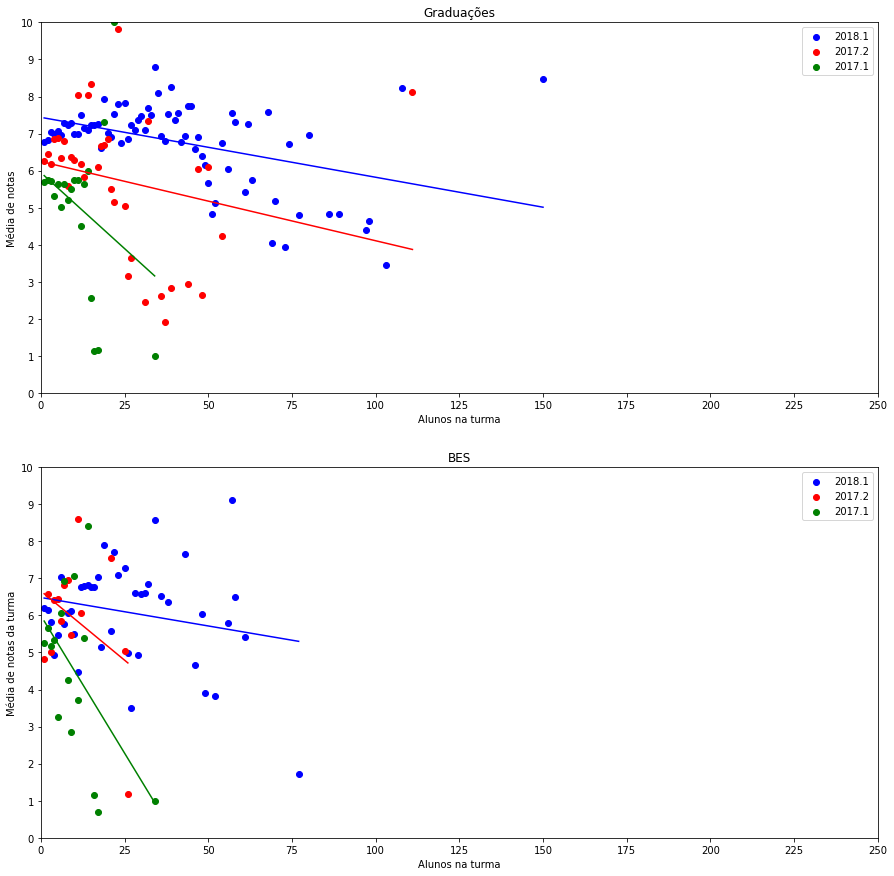

In [ ]:
#Graduações

#Criar scatter plot
plt.subplot(2,1,1)

plt.scatter(x = 'QTD_ALUNOS', y = 'MEDIA_FINAL',  c='blue', data=qtd_20181)
plt.scatter(x = 'QTD_ALUNOS', y = 'MEDIA_FINAL', c='red',  data=qtd_20172)
plt.scatter(x = 'QTD_ALUNOS', y = 'MEDIA_FINAL', c='green',  data=qtd_20171)

plt.legend(labels=["2018.1", "2017.2", "2017.1"], loc="upper right")

#Tendência (polinomial)
z = np.polyfit(x_20181, y_20181, 1)
p = np.poly1d(z)
plt.plot(x_20181, p(x_20181),"b-")

z = np.polyfit(x_20172, y_20172, 1)
p = np.poly1d(z)
plt.plot(x_20172, p(x_20172),"r-")

z = np.polyfit(x_20171, y_20171, 1)
p = np.poly1d(z)
plt.plot(x_20171, p(x_20171),"g-")

plt.xlim(0, 250)
plt.ylim(0, 10)


plt.locator_params(axis="x", nbins=12)
plt.locator_params(axis="y", nbins=10)

plt.title('Graduações')
plt.xlabel('Alunos na turma')
plt.ylabel('Média de notas')

#BES

#Criar scatter plot
plt.subplot(2,1,2)

plt.scatter(x = 'QTD_ALUNOS', y = 'MEDIA_FINAL',  c='blue', data=qtd_bes20181)
plt.scatter(x = 'QTD_ALUNOS', y = 'MEDIA_FINAL', c='red',  data=qtd_bes20172)
plt.scatter(x = 'QTD_ALUNOS', y = 'MEDIA_FINAL', c='green',  data=qtd_bes20171)

plt.legend(labels=["2018.1", "2017.2", "2017.1"], loc="upper right")

#Tendência (polinomial)

z = np.polyfit(x_bes_20181, y_bes_20181, 1)
p = np.poly1d(z)
plt.plot(x_bes_20181,p(x_bes_20181),"b-")

z = np.polyfit(x_bes_20172, y_bes_20172, 1)
p = np.poly1d(z)
plt.plot(x_bes_20172,p(x_bes_20172),"r-")

z = np.polyfit(x_bes_20171, y_bes_20171, 1)
p = np.poly1d(z)
plt.plot(x_bes_20171,p(x_bes_20171),"g-")

plt.xlim(0, 250)
plt.ylim(0, 10)

plt.locator_params(axis="x", nbins=12)
plt.locator_params(axis="y", nbins=10)

plt.title('BES')
plt.xlabel('Alunos na turma')
plt.ylabel('Média de notas da turma')

plt.rcParams['figure.figsize'] = [15, 15]
plt.savefig('plot_notas.jpg')
plt.show()

In [ ]:
#Baixar os gráficos de notas

files.download('plot_notas.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Scatterplot: trancamentos x tamanho da turma**

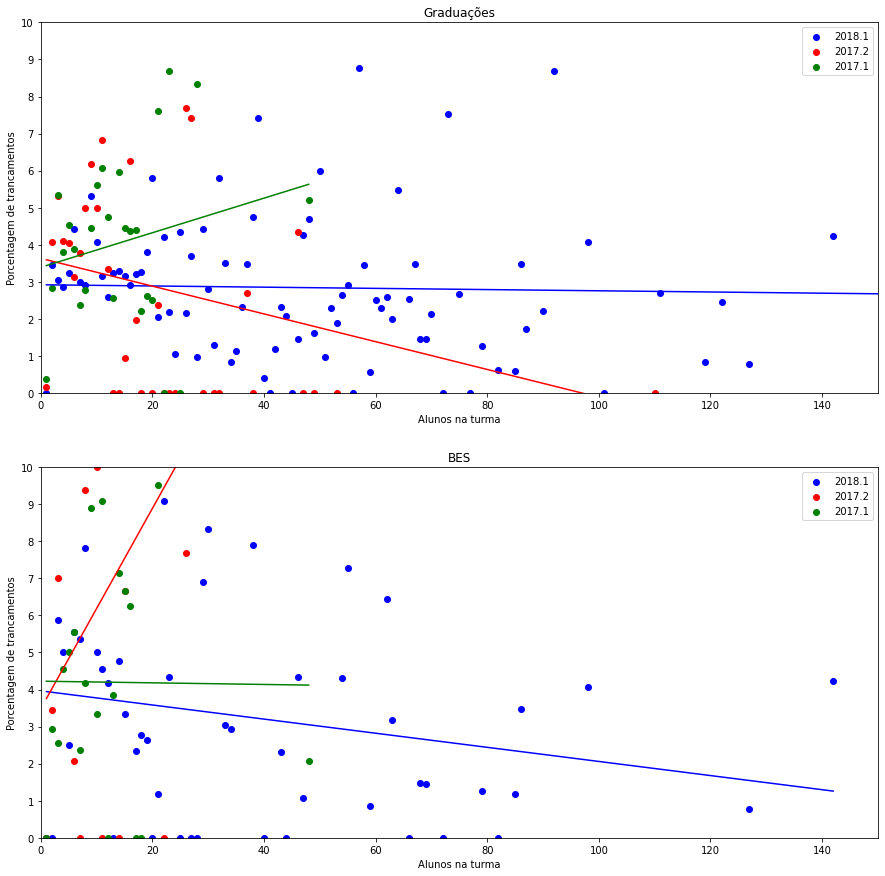

In [ ]:

# Para a Graduação

#Criar scatter plot

plt.subplot(2,1,1)

plt.scatter(x = 'QTD_ALUNOS', y = 'PORCENTAGEM_TRANCAMENTOS',  c='blue', data=qtd_20181)
plt.scatter(x = 'QTD_ALUNOS', y = 'PORCENTAGEM_TRANCAMENTOS',  c='red', data=qtd_20172)
plt.scatter(x = 'QTD_ALUNOS', y = 'PORCENTAGEM_TRANCAMENTOS',  c='green', data=qtd_20171)

plt.legend(labels=["2018.1", "2017.2", "2017.1"], loc="upper right")

plt.xlim(0, 150)
plt.ylim(0, 10)
plt.locator_params(axis="x", nbins=12)
plt.locator_params(axis="y", nbins=10)

#Tendência (polinomial)


z = np.polyfit(x_tranc_grad_20181, y_tranc_grad_20181, 1)
p = np.poly1d(z)
plt.plot(x_tranc_grad_20181, p(x_tranc_grad_20181),"b-")

z = np.polyfit(x_tranc_grad_20172, y_tranc_grad_20172, 1)
p = np.poly1d(z)
plt.plot(x_tranc_grad_20172, p(x_tranc_grad_20172), "r-")

z = np.polyfit(x_tranc_grad_20171, y_tranc_grad_20171, 1)
p = np.poly1d(z)
plt.plot(x_tranc_grad_20171, p(x_tranc_grad_20171), "g-")


plt.title('Graduações')
plt.xlabel('Alunos na turma')
plt.ylabel('Porcentagem de trancamentos')

# para o BES
plt.subplot(2,1,2)

plt.scatter(x = 'QTD_ALUNOS', y = 'PORCENTAGEM_TRANCAMENTOS',  c='blue', data=qtd_bes20181)
plt.scatter(x = 'QTD_ALUNOS', y = 'PORCENTAGEM_TRANCAMENTOS',  c='red', data=qtd_bes20172)
plt.scatter(x = 'QTD_ALUNOS', y = 'PORCENTAGEM_TRANCAMENTOS',  c='green', data=qtd_bes20171)

plt.legend(labels=["2018.1", "2017.2", "2017.1"], loc="upper right")

#Tendência (polinomial)
z = np.polyfit(x_tranc_bes, y_tranc_bes, 1)
p = np.poly1d(z)

plt.xlim(0, 150)
plt.ylim(0, 10)
plt.locator_params(axis="x", nbins=12)
plt.locator_params(axis="y", nbins=10)

z = np.polyfit(x_tranc_bes_20181, y_tranc_bes_20181, 1)
p = np.poly1d(z)
plt.plot(x_tranc_bes_20181, p(x_tranc_bes_20181),"b-")

z = np.polyfit(x_tranc_bes_20172, y_tranc_bes_20172, 1)
p = np.poly1d(z)
plt.plot(x_tranc_bes_20172, p(x_tranc_bes_20172), "r-")

z = np.polyfit(x_tranc_bes_20171, y_tranc_bes_20171, 1)
p = np.poly1d(z)
plt.plot(x_tranc_bes_20171, p(x_tranc_bes_20171), "g-")

plt.title('BES')
plt.xlabel('Alunos na turma')
plt.ylabel('Porcentagem de trancamentos')

plt.rcParams['figure.figsize'] = [15, 10]
plt.savefig('plot_trancamentos.jpg')
plt.show()


In [ ]:

#Baixar os gráficos de trancamento
files.download('plot_trancamentos.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>